<a href="https://colab.research.google.com/github/spiky-ganglia/action-selection/blob/master/Action_Selection_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Moment-to-Moment Action Selection NeuroMatch Dataset provided by Jeffrey Markowitz
by email July 22, 2020 \\
re: [The Striatum Organizes 3D Behavior via Moment-to-Moment Action Selection](https://www.cell.com/cell/pdf/S0092-8674(18)30512-9.pdf)

In [1]:
# load repository if not already loaded
import os

if not os.path.exists('/content/action-selection'):
  os.system('git clone https://github.com/spiky-ganglia/action-selection.git')
else:
  print('The repository data is already loaded')

### Jeffrey's notebook

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%load_ext nb_black

In [3]:
import h5py
#import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:
use_file = 'data/neuromatch_export.h5'

In [5]:
def printall(name, obj):
    print(name, dict(obj.attrs))

In [6]:
with h5py.File(use_file, "r") as f:
    # each session is mapped to a uuid
    uuids = list(f.keys())
    
    # print the attributes for a single dataset
    f[uuids[0]].visititems(printall) 
    
    # load in the data for the first session
    dspn_dff = f[uuids[0]]["dspn_dff"][()].ravel()
    ispn_dff = f[uuids[0]]["ispn_dff"][()].ravel()
    timestamps = f[uuids[0]]["timestamps"][()].ravel()
    syllables = f[uuids[0]]["syllables"][()].ravel()

mouse_id {'dtype': 'string', 'description': 'ID of mouse'}
ispn_dff {'dtype': 'single', 'description': 'df/f for ispns (GCaMP)'}
dspn_dff {'dtype': 'single', 'description': 'df/f for dspns (RCaMP)'}
timestamps {'dtype': 'single', 'description': 'timestamps in seconds'}
date {'dtype': 'string', 'description': 'date of session'}
syllables {'dtype': 'int16', 'description': 'Syllable labels (sorted by usage)'}


In [7]:
# random shuffle the index of the jet colour map
vals = np.linspace(0,1,256)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.jet(vals))

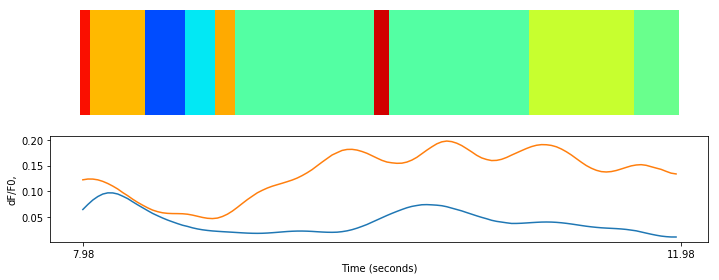

In [8]:
# plot a slice of ispn and dspn data vs timestamps
fig, ax = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
plt_pts = slice(240, 360)
ax[0].imshow(np.tile(syllables[plt_pts], [100, 1]), aspect="auto", cmap=cmap)
ax[0].axis("off")
ax[1].plot(ispn_dff[plt_pts])
ax[1].plot(dspn_dff[plt_pts] * 10)
ax[1].set_xticks((0, (plt_pts.stop - plt_pts.start)))
ax[1].set_xticklabels(np.around(timestamps[[plt_pts.start, plt_pts.stop]], 2))
ax[1].set_xlabel("Time (seconds)")
ax[1].set_ylabel("dF/F0,")
plt.tight_layout()

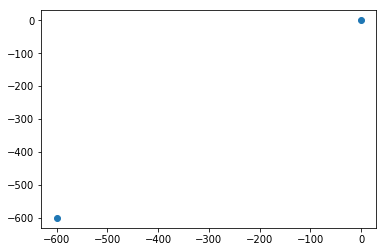

In [79]:
# Simple PCA on iSPN, dSPN, and both
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)

# Create points
x = np.reshape(timestamps, (35982, 1))
y = np.nan_to_num(ispn_dff)
y = np.reshape(y, (35982, 1))
points = np.hstack((x, y))

# Fit PCA
X_pca = pca.fit_transform(points)

#Plot
plt.figure()
plt.scatter(X_pca[0], X_pca[1])

In [121]:
# Simple RNN - features and labels

features = []
labels = []
sylls = []

training_length = 5
predict_length = 1

for s in syllables:
    if s != -5:
        sylls.append(s)
        
print(len(sylls))
max_syll = np.max(sylls)+1

for i in range(training_length, len(sylls)-predict_length):
    extract = sylls[i - training_length:i+predict_length]
    features.append(extract[:5])
    labels.append(extract[5:])
    
features = np.array(features)
labels = np.array(labels)
labels.shape

35981


(35975, 1)

In [124]:
# One hot encode
one_hot_labels = np.zeros((labels.shape[0], max_syll), dtype=np.int8)

for i, j in enumerate(labels):
    one_hot_labels[i, labels[i]] = 1
    
one_hot_labels.shape

(35975, 96)

In [125]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, one_hot_labels, test_size=0.20, shuffle=False)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(28780, 5)
(28780, 96)
(7195, 5)
(7195, 96)


In [127]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding

model = Sequential()

# Embedding layer
model.add(
    Embedding(input_dim=X_train.shape[0],
              input_length = training_length,
              output_dim=100,
              trainable=True))

# Recurrent layer
model.add(LSTM(64, return_sequences=False, 
               dropout=0.1, recurrent_dropout=0.1))

# Fully connected layer
model.add(Dense(64, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Dense(max_syll, activation='softmax'))

In [128]:
from keras.callbacks import EarlyStopping
# Create callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

In [129]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [130]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 5, 100)            2878000   
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 96)                6240      
Total params: 2,930,640
Trainable params: 2,930,640
Non-trainable params: 0
_________________________________________________________________


In [131]:
history = model.fit(X_train,  y_train, 
                    batch_size=2048, epochs=300,
                    callbacks=callbacks,
                    validation_data=(X_test, y_test))

Train on 28780 samples, validate on 7195 samples
Epoch 1/300
28780/28780 [==============================] - 6s 205us/step - loss: 4.5210 - acc: 0.1870 - val_loss: 4.4568 - val_acc: 0.4479
Epoch 2/300
28780/28780 [==============================] - 3s 113us/step - loss: 4.3284 - acc: 0.3024 - val_loss: 4.1211 - val_acc: 0.3154
Epoch 3/300
28780/28780 [==============================] - 3s 111us/step - loss: 3.7215 - acc: 0.2132 - val_loss: 3.3337 - val_acc: 0.2086
Epoch 4/300
28780/28780 [==============================] - 3s 110us/step - loss: 3.0940 - acc: 0.2507 - val_loss: 2.7900 - val_acc: 0.4171
Epoch 5/300
28780/28780 [==============================] - 3s 109us/step - loss: 2.6355 - acc: 0.4009 - val_loss: 2.2843 - val_acc: 0.5368
Epoch 6/300
28780/28780 [==============================] - 3s 112us/step - loss: 2.2585 - acc: 0.5191 - val_loss: 1.9392 - val_acc: 0.6571
Epoch 7/300
28780/28780 [==============================] - 3s 114us/step - loss: 1.9899 - acc: 0.6025 - val_loss: 1.7

28780/28780 [==============================] - 3s 111us/step - loss: 0.6610 - acc: 0.9194 - val_loss: 0.6392 - val_acc: 0.9181
Epoch 60/300
28780/28780 [==============================] - 3s 114us/step - loss: 0.6548 - acc: 0.9192 - val_loss: 0.6436 - val_acc: 0.9181
Epoch 61/300
28780/28780 [==============================] - 3s 119us/step - loss: 0.6583 - acc: 0.9197 - val_loss: 0.6374 - val_acc: 0.9183
Epoch 62/300
28780/28780 [==============================] - 3s 120us/step - loss: 0.6572 - acc: 0.9201 - val_loss: 0.6370 - val_acc: 0.9183


In [150]:
print(syllables[120:125])
print(syllables[126])
inp = np.array(syllables[120:125]).reshape((1,5))

a = model.predict(inp)
a[0, 28]

[29 29 29 29 29]
29


2.5033241e-05

### resources

link | what it's for
--- | ---
[Python and HDF5](https://docs.google.com/viewer?a=v&pid=sites&srcid=b2JqZWN0bWFnZS5jb218cHJpdmF0ZS10cmFpbmluZ3xneDoyNWIzNmI3YWFhOTFmMjU2) | h5py info in book format
[HDF - EOS Tools and Information Centre](http://hdfeos.org/software/tool.php) | NASA recommended (and not recommended) software tools for HDF files 
[seaborn introduction](https://seaborn.pydata.org/introduction.html) | seaborn introduces itself
[Offical seaborn tutorial](https://seaborn.pydata.org/tutorial.html#tutorial) | by Michael Waskom (also course reviewer for Neuromatch Academy courses)
[Pandas tutorials](https://pandas.pydata.org/pandas-docs/stable/getting_started/tutorials.html) | Pandas' reference to various tutorials and getting started guides
[supplemental information](https://www.cell.com/cell/fulltext/S0092-8674(18)30512-9?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867418305129%3Fshowall%3Dtrue) | for the paper "The Striatum Organizes 3D Behavior via Moment-to-Moment Action Selection"


### data records
* recorded at 30 Hz, 33.33 ms per record
* 20 minutes of activity in dataset
* max slice number 35979

### project tasks

Organise tasks by priority:

task | possible methodology | completed?
--- | --- | ---
find `date` and `mouse_id` values | use hdf5 to extract and list values | yes
what data are in each dataset? | use hdf5 to list dataset structures | yes
how many unique syllables per dataset? | use hdf5 to access syllable data and count unique syllables | yes
split out syllable sequences by -5 syllable marker | use hdf5 to find start of syllable sequences and save each sequence | no


### datasets summary

We assume that each record (or row) in a dataset is sequential in time, as given by the use of the timestamps column in the plots above. It would be a good idea though to check if all timestamps are in sequence and without missing data.

### Dataset record size

Each dataset has differing record sizes and record sizes can vary within a dataset. Syllables often have smaller sizes.

In [25]:
with h5py.File(use_file, "r") as f:

  # each session is mapped to a uuid
  uuids = list(f.keys())
  print('Number of datasets:', len(uuids))

  for key in range(len(uuids)):
    print(uuids[key])
    dspn_dff = f[uuids[0]]["dspn_dff"][()].ravel()
    ispn_dff = f[uuids[0]]["ispn_dff"][()].ravel()
    timestamps = f[uuids[0]]["timestamps"][()].ravel()
    syllables = f[uuids[key]]["syllables"][()].ravel()
    ispn_dff = f[uuids[0]]["ispn_dff"][()].ravel()
    print('Record size for dspn, ispn, timestamps, syllables:')
    print(dspn_dff.shape[0], ispn_dff.shape[0], timestamps.shape[0], syllables.shape[0])
    print()

Number of datasets: 48
11a979f0-c3eb-4860-98bc-942e85986af7
Record size for dspn, ispn, timestamps, syllables:
35979 35979 35979 35979

141a4484-a55e-4a72-a202-6458493482b0
Record size for dspn, ispn, timestamps, syllables:
35979 35979 35979 35959

221e3512-1bfd-4f12-ad1f-e7f34c91d291
Record size for dspn, ispn, timestamps, syllables:
35979 35979 35979 35978

235fecc5-f01d-4605-9efc-56736a96b824
Record size for dspn, ispn, timestamps, syllables:
35979 35979 35979 35977

2924d8bb-9226-4799-916d-e751340b31a5
Record size for dspn, ispn, timestamps, syllables:
35979 35979 35979 35983

2c50ef9a-be62-4888-8ab0-f4dd0ca80f2c
Record size for dspn, ispn, timestamps, syllables:
35979 35979 35979 35983

37163d2d-280a-4982-acec-a11b717e86d2
Record size for dspn, ispn, timestamps, syllables:
35979 35979 35979 35959

3a919b3a-d8ce-4f30-80c5-64ad44e54894
Record size for dspn, ispn, timestamps, syllables:
35979 35979 35979 35979

3bc8b711-b02e-4a13-a2a1-613ad50f6da8
Record size for dspn, ispn, timestam

### date field

Each dataset has a unique date and time.

In [16]:
with h5py.File(use_file, "r") as f:

  # each session is mapped to a uuid
  uuids = list(f.keys())
  print('Number of datasets:', len(uuids))

  for key in range(len(uuids)):
    print(uuids[key])
    date_ = f[uuids[key]]["date"][()].ravel()
    print(date_)
    print()

Number of datasets: 48
11a979f0-c3eb-4860-98bc-942e85986af7
['01-Jul-2017 11:07:02']

141a4484-a55e-4a72-a202-6458493482b0
['09-Jun-2017 18:23:24']

221e3512-1bfd-4f12-ad1f-e7f34c91d291
['28-Jun-2017 16:22:01']

235fecc5-f01d-4605-9efc-56736a96b824
['28-Apr-2017 14:39:03']

2924d8bb-9226-4799-916d-e751340b31a5
['12-Jun-2017 18:01:03']

2c50ef9a-be62-4888-8ab0-f4dd0ca80f2c
['18-Jul-2017 13:17:43']

37163d2d-280a-4982-acec-a11b717e86d2
['14-Jun-2017 17:57:00']

3a919b3a-d8ce-4f30-80c5-64ad44e54894
['22-Jun-2017 15:49:57']

3bc8b711-b02e-4a13-a2a1-613ad50f6da8
['09-May-2017 12:22:04']

40424ad3-bc2b-42b5-895a-300a23be355c
['22-Jun-2017 16:50:54']

4695bf1e-9561-4dfb-9371-58cd33282cf1
['08-Jun-2017 18:43:29']

518b4218-64bd-4f34-ab60-0b5b3e988bc8
['27-Jun-2017 17:32:19']

520266a4-2ccb-4601-b39e-82a342d99f60
['03-Jun-2017 10:33:09']

5aa0211f-3692-4b46-a821-d06d17ef7227
['18-Jul-2017 15:03:34']

5e43deab-1e6b-42f4-9a9f-93f6fd7e3493
['19-Jun-2017 16:35:23']

62437e0c-d207-4078-ab81-06313dc3

### mouse id

There are 8 unique mouse id's.

In [15]:
with h5py.File(use_file, "r") as f:
  # each session is mapped to a uuid
  uuids = list(f.keys())
  mouse_id = []

  for key in range(len(uuids)):
    print(uuids[key])
    mouse_id.append(f[uuids[key]]["mouse_id"][()].ravel())
    print(mouse_id[-1])
    print()

  print('Unique mouse ids:', np.unique(np.array(mouse_id)))
  print ('Number of unique mouse ids:', np.unique(np.array(mouse_id)).shape[0])

11a979f0-c3eb-4860-98bc-942e85986af7
['1538']

141a4484-a55e-4a72-a202-6458493482b0
['1532']

221e3512-1bfd-4f12-ad1f-e7f34c91d291
['1538']

235fecc5-f01d-4605-9efc-56736a96b824
['19938']

2924d8bb-9226-4799-916d-e751340b31a5
['1554']

2c50ef9a-be62-4888-8ab0-f4dd0ca80f2c
['1554']

37163d2d-280a-4982-acec-a11b717e86d2
['19938']

3a919b3a-d8ce-4f30-80c5-64ad44e54894
['1538']

3bc8b711-b02e-4a13-a2a1-613ad50f6da8
['19842']

40424ad3-bc2b-42b5-895a-300a23be355c
['1546']

4695bf1e-9561-4dfb-9371-58cd33282cf1
['1538']

518b4218-64bd-4f34-ab60-0b5b3e988bc8
['1554']

520266a4-2ccb-4601-b39e-82a342d99f60
['1532']

5aa0211f-3692-4b46-a821-d06d17ef7227
['1555']

5e43deab-1e6b-42f4-9a9f-93f6fd7e3493
['1538']

62437e0c-d207-4078-ab81-06313dc366c4
['1546']

673b4dae-5c4e-463e-9ac6-4c48c9aa767b
['1555']

6c1c5645-e3c7-4bc7-93cd-15261fc96495
['1532']

70d80df4-7edc-44e5-b31d-ec274d4857e8
['1555']

746c4e99-3cd6-495c-9f3f-ba27446b67da
['1546']

762bf6a8-608b-49d3-932a-dfb4c3f41ecb
['1555']

76ea893c-3

### dataset structures

There are 48 datasets of similar structure, one for each experiment.

In [14]:
with h5py.File(use_file, "r") as f:
  # each session is mapped to a uuid
  uuids = list(f.keys())
    
  # print the uuid keys and attributes for each dataset
  for key in range(len(uuids)):
    print(uuids[key])
    f[uuids[key]].visititems(printall)
    print()

print('number of database keys:', len(uuids))

11a979f0-c3eb-4860-98bc-942e85986af7
date {'description': 'date of session', 'dtype': 'string'}
dspn_dff {'description': 'df/f for dspns (RCaMP)', 'dtype': 'single'}
ispn_dff {'description': 'df/f for ispns (GCaMP)', 'dtype': 'single'}
mouse_id {'description': 'ID of mouse', 'dtype': 'string'}
syllables {'description': 'Syllable labels (sorted by usage)', 'dtype': 'int16'}
timestamps {'description': 'timestamps in seconds', 'dtype': 'single'}

141a4484-a55e-4a72-a202-6458493482b0
date {'description': 'date of session', 'dtype': 'string'}
dspn_dff {'description': 'df/f for dspns (RCaMP)', 'dtype': 'single'}
ispn_dff {'description': 'df/f for ispns (GCaMP)', 'dtype': 'single'}
mouse_id {'description': 'ID of mouse', 'dtype': 'string'}
syllables {'description': 'Syllable labels (sorted by usage)', 'dtype': 'int16'}
timestamps {'description': 'timestamps in seconds', 'dtype': 'single'}

221e3512-1bfd-4f12-ad1f-e7f34c91d291
date {'description': 'date of session', 'dtype': 'string'}
dspn_dff

### unique syllables per dataset

The number of unique syllables in each dataset varies. It appears that syllable labels remain constant across all datasets (i.e. one label per syllable). There 99 unique syllables across all datasets and the maximum syllable index is 100. The -5 syllable may be a marker defining the start of a motor action.

In [13]:
with h5py.File(use_file, "r") as f:
  # each session is mapped to a uuid
  uuids = list(f.keys())
  syllables_ = []
    
  # print the unique syllables and number for each dataset
  for key in range(len(uuids)):
    print(uuids[key])
    syllables_.append(np.unique(f[uuids[key]]["syllables"][()].ravel()))
    print(syllables_[-1])
    print('Max syllable index:', max(syllables_[-1]))
    print('Number of unique syllables in this dataset:', len(syllables_[-1]))
    print()

syllables__ = []

for s in syllables_:
  syllables__.extend(s)

print('Number of unique syllables in all datasets:', (np.unique(np.array(syllables__))).shape[0])
print('Max syllable index in all datasets:', max(np.unique(np.array(syllables__))))

11a979f0-c3eb-4860-98bc-942e85986af7
[-5  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94]
Max syllable index: 94
Number of unique syllables in this dataset: 95

141a4484-a55e-4a72-a202-6458493482b0
[-5  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 79 80 82 83 84 85 86 88 89 92 93]
Max syllable index: 93
Number of unique syllables in this dataset: 89

221e3512-1bfd-4f12-ad1f-e7f34c91d291
[-5  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60

### Tag syllable sequences

Find `-5` syllable markers in syllable dataset and store row indices into a sequence table. A new hdf5 file is created with the addition of a sequence table for each dataset.

### split dataset syllable data into separate sequences

Create a new hdf5 file with all 48 datasets, each with an index table. To read syllable sequences, slice off sections of a dataset (according to index locations) into numpy arrays to either print or store to a file.

### Remove syllable markers

Create new datasets with each `-5` syllable marker replaced by the next syllable (if just one marker) so that supervised learning is not biased towards learning the marker position as the start of a syllable sequence. Check if all records are in time sequence and if there are missing data.

### spiky-ganglia-project data analysis

Possible goals:
* analyse syllable sequences across datasets
* make nice bar graphs!

In [13]:
import pandas as pd
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### algernon project stored in algernon repository